# Imports

In [258]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy
import os
import glob
import pandas as pd
import math
import sys
plt.rcdefaults() #Setting default color of output plots
# For interactive plots

plt.rcParams.update({'figure.max_open_warning': 0})
%matplotlib widget

# TODO:
    
   1) GRB ID SHOULD BE USED AS INPUT IN MOST FUNCTIONS!! IMPLEMENT THIS 
   2) Correct concatination of multiple files. GRB_ID is used to locate list of files
   2) Use GRBID as input in plotting function, not filename. Don't need this right now tho. FOR LED AND HED
   3) Redo all the plots ...

# Paths

In [10]:
path_HED = "/Home/siv30/wad005/master/GRB/MATLAB/output/file_mat_TGF/"
path_LED = "/Home/siv30/wad005/master/GRB/MATLAB/CZT_calibration/file_mat_CZT_TGF/"
#path_HED = "/Users/andreas/phys/master/GRB/MATLAB/output/file_mat_TGF"
#path_LED = "/Users/andreas/phys/master/GRB/MATLAB/CZT_calibration/file_mat_CZT_TGF"

# Dict creation

In [3]:
#make a dictionary out of the manual trigger_ID list
triggers_data = pd.read_csv("trigger_ID.csv") #Manually created csv file that contains the GRB IDs, LED and HED filenames
GRB = triggers_data["GRB"].values
LED = triggers_data["LED"].values
HED = triggers_data["HED"].values
#Should be an easier way to sort the DF into an dict. Maybe transposing the DF
def create_triggers_dict():
    """
    trig_dict stores the GRB ID and LED/HED filenames.
    Key in dictionary is GRB id. Filenames are stored as tuple <LED,HED>
    return: trig_dict
    """
    trig_dict ={}
    
    try:
        if len(LED) & len(HED) != len(GRB):
            raise IndexError("Arrays not the same length. Check GRB,LED and HED")
        else:
            for i in np.arange(0,len(GRB)):
                GRB_name = GRB[i]
                LED_id = LED[i]
                HED_id = HED[i]
                trig_dict[GRB_name] = LED_id,HED_id
            return trig_dict
    except:
        raise

In [200]:
trig_dict_HED = {"GRB180720":["2018_07_20_14_21_48","2018_07_20_14_21_51","2018_07_20_14_21_56","2018_07_20_14_21_57","2018_07_20_14_22_09"],
                 "GRB181222":["2018_12_22_20_11_36"],
                 "GRB190206":["2019_02_06_03_49_28"],
                 "GRB190305":["2019_03_05_13_05_19"],
                 "GRB190501":["2019_05_01_05_23_22"],
                 "GRB190606":["2019_06_06_01_55_07"],
                 "GRB190615":["2019_06_15_14_42_21"],
                 "GRB190813":["2019_08_13_12_00_49"],
                 "GRB190825":["2019_08_25_21_04_53","2019_08_25_21_04_55"],
                 "GRB190829":["2019_08_29_19_56_40"],
                 "GRB190906":["2019_09_06_01_04_51"],
                 "GRB191001":["2019_10_01_06_41_52"],
                 "GRB200412":[],# long list
                 "GRB200521":["2020_05_21_12_16_39"],
                 "GRB200716":["2020_07_16_22_57_40"],
                 "GRB200925":["2020_09_25_21_50_31"],
                 "GRB201227":["2020_12_27_15_14_06"]
                
                
                
                }

In [203]:
trig_dict_LED = {"GRB181227":["2018_12_27_06_17_04.210500_Fulltrigger","2018_12_27_06_17_09.775992_Fulltrigger","2018_12_27_06_17_10.800851_Fulltrigger"],
                "GRB190117":["2019.01.17_08.50.42.939689_Fulltrigger"],
                 "GRB190420":["2019.04.20_23.32.24.931211_Fulltrigger"],
                 "GRB190501":["2019.05.01_05.23.21.736797_Fulltrigger"],
                 "GRB190615":["2019.06.15_14.42.22.741579_Fulltrigger"],
                 "GRB190628":["2019.06.28_04.23.32.512290_Fulltrigger"],
                 "GRB190813":["2019.08.13_12.00.48.801260_Fulltrigger"],
                 "GRB190825":["2019.08.25_21.04.54.439617_Fulltrigger","2019.08.25_21.04.56.395859_Fulltrigger"],
                 "GRB190906":["2019.09.06_01.04.52.014004_Fulltrigger"],
                 "GRB191001":["2019.10.01_06.41.51.631214_Fulltrigger"],
                 
                 
                 
                }

# Functions for handling matlab files

## CZT function

In [132]:
def read_matlab_file_with_CZT_data(filename):
    '''Read matlab file with ASIM CZT data from the low energy detector (LED)

    tus: relative time in microseconds (excluded multihits)
    erg: energy channel (excluded multihits)
    energy_keV: energy in keV (excluded multihits)
    tus_keep_multihit: relative time in microseconds (included multihits)
    erg_keep_multihit: energy channel (included multihits)
    multihit_indx: multihit index 0-4. 0->1 1->2// 0: tus=105, 1: tus=110,110 (two counts)
    '''
    mat = scipy.io.loadmat(path_LED + "%s.mat" % (filename))

    #keV_spectra = mat['keV_spectra_total_fulltrigger']

    # Included multihits. Important for light curves
    tus_keep_multihit = np.array(mat['tus_keep_multihit_fulltrigger'])[:,0] # relative time in microseconds
    erg_keep_multihit = np.array(mat['erg_keep_multihit_fulltrigger'])[0,:] # energy channel (unreliable for multi hits)
    multihit_indx = np.array(mat['multihit_fulltrigger'])[0,:] # multihit index. How many multihits in count. (0=1 count, 1=2 counts, 2=3 counts...)
    
    # The multihits are removed as they don't have a reliable energy estimate
    erg = np.array(mat['erg_fulltrigger'])[0,:] # energy channel of CZT pixel
    tus = np.array(mat['tus_fulltrigger'])[:,0] # relative time in microseconds
    energy_keV = np.array(mat['pixel_energy_fulltrigger']).flatten() # energy in keV of CZT pixel
    
    
    #Logic that checks for array lengths
    try:
        length = len(tus_keep_multihit)
        if any(len(lst) != length for lst in [erg_keep_multihit, multihit_indx]):
        # at least one list has a different length
            raise ValueError("Arrays have different lengths")
            
        t_temp = []
        erg_temp = []
        
        for index, i in enumerate(multihit_indx):
            for j in np.arange(0,i+1): #adding i+1 times the tus_count
                t_temp.append(tus_keep_multihit[index])
                erg_temp.append(erg_keep_multihit[index])
         
        tus_keep_multihit_ntimes =  np.array(t_temp) #array of tus. Multihit index decides how many times the tus is appended
        erg_keep_multihit_ntimes = np.array(erg_temp) #array of erg. Multihit index decides how many times the erg is appended
        
        return tus, erg, energy_keV, tus_keep_multihit_ntimes, erg_keep_multihit_ntimes, multihit_indx 
    
    except ValueError as ve:
        print("Function aborted because of: " + str(ve))
        print("Length of arrays: ")
        for lst in [tus_keep_multihit, erg_keep_multihit, multihit_indx]:
            print(len(lst))

## BGO function

In [109]:
def read_matlab_file_with_BGO_data(matlabfilename):
    '''Read matlab file with ASIM BGO data from the high energy detector (HED)

    tus: relative times in microseconds.
    erg: energy channel (needs to be calibrated to keV using calibration coeff from https://git.app.uib.no/ASIM-MXGS/IN-FLIGHT_CALIBRATION_BGO/-/tree/master/CALIBRATION_COEFS )
    typ: normal (0), fast(1), valley (3), or overflow event (2 or 4 not )
    adr: BGO address 1-12
    dau: dau address 1-4
    det: detector address 1-3
    DetCol: RGB color
    
    - Kepping only normal (0) and fast (1) events
    '''
    matlabfile_TGF = path_HED + '%s.mat' % matlabfilename
    
    mat = scipy.io.loadmat(matlabfile_TGF)
    
    tus = mat['tus'].flatten()
    erg = mat['erg'].flatten()
    DetCol = mat['DetCol'] # Investigate this matrix
    adr = mat['adr'].flatten()
    dau = mat['dau'].flatten()
    det = mat['det'].flatten()
    typ = mat['typ'].flatten()
    
    date = mat['date'].flatten() #raw datetime
    
    
    try:
        length = len(tus)
        if any(len(lst) != length for lst in [erg, typ, adr, dau, det]):
        # at least one list has a different length
            raise ValueError("Arrays have different lengths")
            
        mask = np.where((typ != 0) & (typ != 1)) #finding indecies of vallays and overflow events
        
        # removing those indecies
        tus = np.delete(tus,mask)
        erg = np.delete(erg,mask)
        adr = np.delete(adr,mask)
        dau = np.delete(dau,mask)
        det = np.delete(det,mask)
        typ = np.delete(typ,mask)
        
        
        return tus, erg, typ, adr, dau, det, DetCol, date
    
    except ValueError as ve:
        print("Function aborted because of: " + str(ve))
        print("Length of arrays: ")
        for lst in [tus,erg, typ, adr, dau, det]:
            print(len(lst))

# Plotting functions

## LED

In [187]:
def plot_LED(LED_filename, binsize=10,start_range =0, end_range=0):
    tus_LED, erg_LED, energy_keV_LED, tus_keep_multihit_LED, erg_keep_multihit_LED, multihit_indx_LED = read_matlab_file_with_CZT_data(
    LED_filename)

    binsize = binsize*1e3 #converting to microseconds
    start_range = start_range*1e3 #converting to microseconds
    end_range = end_range*1e3
    
    fig0, ax1 = plt.subplots(
        1, 1, figsize=(12, 8), sharex=True, sharey=False)
    
    ax1.hist(tus_keep_multihit_LED, bins=np.arange(
        min(tus_keep_multihit_LED), max(tus_keep_multihit_LED) + binsize, binsize),edgecolor= "black", histtype="step")
    ax1.set_xlabel("time [us], binsize {} ms".format((binsize / 1e3)))
    ax1.set_ylabel("Counts per bin")
    ax1.set_title("GRB " + LED_filename)
    
    if start_range and end_range != 0:
        mean = get_mean(LED_filename,binsize,tus_LED, start_range, end_range)
        ax1.axhline(y=mean, color="red", label="Mean of bg: {} counts/bin \n First range [{} - {}] s \n 2nd: [{} - {}] s".format(
            np.round(mean,2), np.round(min(tus_LED)/1e6,3),start_range/1e6, end_range/1e6, np.round(max(tus_LED)/1e6,3)),linestyle='--')
                                                                                                                              
                                                                                                                          
        ax1.legend()
        plt.show()
    else:
        plt.show()
        
    #plt.savefig(output_dir + "/{}_LED".format(grb_id))

    

## HED

In [265]:
def plot_HED(HED_filename, binsize=10, start_GRB=0, end_GRB=0, fig=(12,8) ):
    
    """Plotting data from HED.
        If start and end value for the GRB is not given, the data is plotted normally,
        - BINSIZE IS INITIALIZED AS MILLISECONDS
        - start_GRB & end_GRB IS INITIALIZED AS MILLISECONDS 0.5 s = 500 ms
        - tus_HED is given in microseconds
    """
    
    binsize = binsize*1e3 #converting to microseconds\n",
    
    start_GRB = start_GRB*1e3 #converting to microseconds\n",
    end_GRB = end_GRB*1e3,

    tus_HED, erg_HED, typ_HED, adr_HED, dau_HED, det_HED, DetCol_HED, date = read_matlab_file_with_BGO_data(HED_filename)
    
    fig0, ax1 = plt.subplots(
        1, 1, figsize=fig, sharex=True, sharey=False)
    ax1.hist(tus_HED, bins=np.arange(
        min(tus_HED), max(tus_HED) + binsize, binsize),edgecolor= "black", histtype="step")
    
    ax1.set_xlabel("time [us], binsize {} ms".format((binsize / 1e3)))
    ax1.set_ylabel("Counts per bin"),
    ax1.set_title("GRB" + HED_filename) #use dict to get id


    if start_GRB and end_GRB != 0:
        mean = get_mean(HED_filename,binsize,tus_HED, start_GRB, end_GRB)
        ax1.axhline(y=mean, color="red", label= "Mean of bg: {} counts/bin \n First range [{} - {}] s \n 2nd: [{} - {}] s".format(
            np.round(mean,2), np.round(min(tus_HED)/1e6,3),start_GRB/1e6, end_GRB/1e6, np.round(max(tus_HED)/1e6,3)),linestyle='--'),
        ax1.legend()
        plt.show(),
    else:
        plt.show()

## mean

In [213]:
# Rename start_GRB to start_range. Same for end_GRB
def get_mean(matlab_filename, binsize, tus, start_GRB, end_GRB):
    
    """Function for getting the mean from the background.
    matlab_filename: <str> filename
    binsize: <int> given in us // 5ms = 5000 us 
    start & end_GRB given in us.
    -Finding ranges to compute the mean in each bin. """
    
    tus = np.sort(tus)
    range_1 =  find_closest(tus,start_GRB)
    range_2 = find_closest(tus,end_GRB)
    
    range_1_counts = np.histogram(tus[:range_1], bins=np.arange(
        min(tus[:range_1]), max(tus[:range_1]) + binsize, binsize))[0]
    
    range_2_counts = np.histogram(tus[range_2:], bins=np.arange(
        min(tus[range_2:]), max(tus[range_2:]) + binsize, binsize))[0]
    
    background_data = np.append(range_1_counts,range_2_counts)
    mean = np.mean(background_data)
    return mean

In [214]:
def find_closest(A, target):
    #A must be sorted
    idx = A.searchsorted(target)
    idx = np.clip(idx, 1, len(A)-1)
    left = A[idx-1]
    right = A[idx]
    idx -= target - left < right - target
    return idx

# Concatination of multiple files
    -defining function concat_files

In [255]:
def concat_files(grb_id, flag):
    """ function concat_files concatenates multiple matlab files. Can only concat HED or LED files at the time
    
    Flag determines whether the input list is of HED or LED files
    
    Routine description: 
    1) The different tus arrays have their own T0. Calculating the delta T between T0 and Tn (time for concatination)  
    
    
    Parameters:
    %---------------------------------------------------------------
    
    grb_id <string>  : key for dictionary containing list of matlab filenames
    flag <string>    : "HED" or "LED". They have different arrays after calling read_matlab_file function. This flag handles that.
    
    
    returns:
    %---------------------------------------------------------------
    
    
    output for HED:
    %---------------------------------------------------------------
    concat_tus_HED <array> : concat tus (relative times in microseconds) for all arrays
    concat_erg_HED <array> : concat erg (energy channel (needs to be calibrated to keV using calibration coeff)) for all arrays
    concat_typ_HED <array> : concat typ for all counts  (normal (0), fast(1), valley (3), or overflow event (2 or 4 not )) read function keeps only 0 & 1.
    concat_adr_HED <array> : concat BGO address 1-12 for all arrays
    concat_dau_HED <array> : concat dau address 1-4
    concat_det_HED <array> : concat detector address 1-3
    concat_DetCol_HED <array> : concat RGB color for all arrays
    concat_date_HED <array> : datetime of T0 for concat array
    
    output for LED:
    %----------------------------------------------------------------
    
    
    """
    #Handling input is in the right format
    try:
        if type(flag) and type(grb_id) != str:
            raise TypeError("grb_id and/or flag input is not string")
        if flag != "HED" and flag != "LED":
            raise NameError("flag-string is neither HED or LED")
        if flag == "HED":
            if grb_id not in trig_dict_HED.keys():
                raise KeyError("GRB ID not in trig_dict_HED")
        if flag == "LED":
            if grb_id not in trig_dict_LED.keys():
                raise KeyError("GRB ID not in trig_dict_LED")
        else:
            if flag == "HED":
                HED_files = trig_dict_HED[grb_id] #list of HED filenames in list. 
            if flag == "LED":
                LED_files = trig_dict_LED[grb_id] #list of LED filenames in list
                
    except (TypeError, NameError, KeyError) as e:
        return print(e) #routine quits if error is found
    
    
    #reading the matlab files --> storing in matrix?
    
    
    print("no errors found")


## Testing concat

In [254]:
concat_files("GRB190206","HED")


no errors found


In [ ]:
tus_HED, erg_HED, typ_HED, adr_HED, dau_HED, det_HED, DetCol_HED, date = read_matlab_file_with_BGO_data(HED_filename)

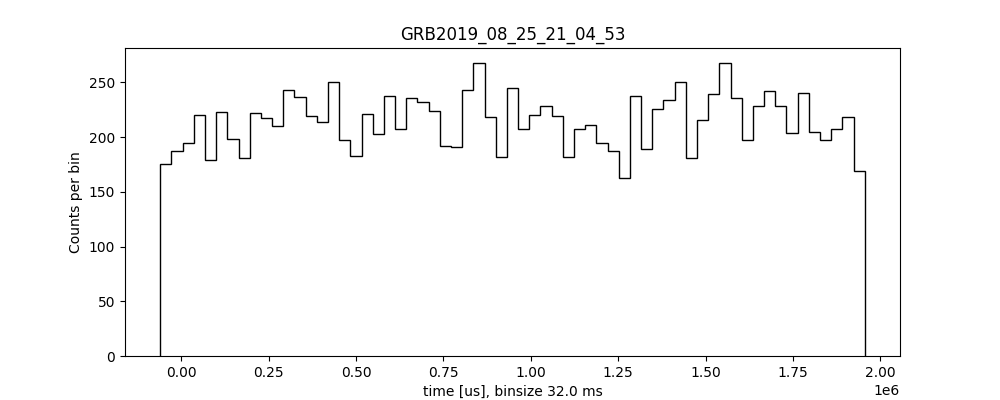

In [268]:
plot_HED("2019_08_25_21_04_53",binsize=32, fig=(10,4))

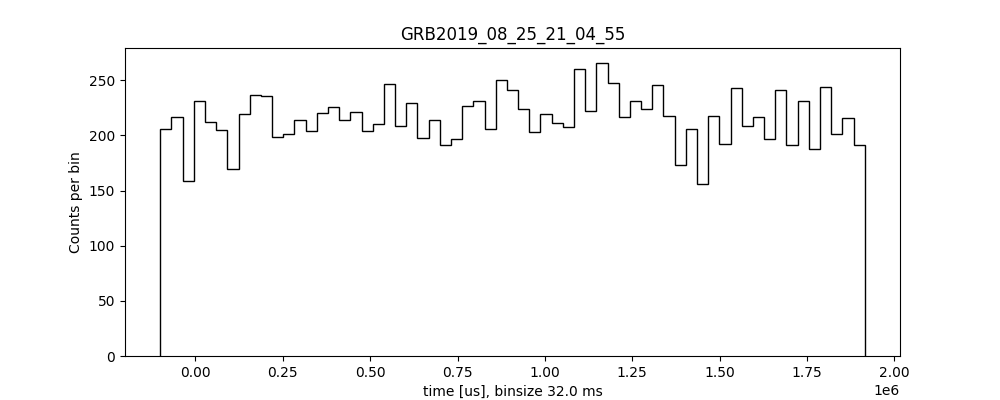

In [269]:
plot_HED("2019_08_25_21_04_55",binsize=32, fig=(10,4))

# main function

In [8]:
def main(grb_id,binsize=10000, start_GRB, end_GRB):  # filename GRB ID
    # output array for tus_keep_multihit_LED, erg_keep_multihit_LED, multihit_indx_LED må modifiseres
    # Automake by making filename a list of filenames. Then the all the outout plots will be created

    # TODO:
    # Add the extra parameters to make the get_mean work
#os.mkdir("/Users/andreas/phys/master/MATLAB/pyplots")
    trig_dict = create_triggers_dict()
    try:
        output_dir = os.mkdir("/Home/siv30/wad005/master/GRB/MATLAB/pyplots/{}".format(grb_id)) #Creating owd folder for grb_id
    except FileExistsError:
        output_dir = "/Home/siv30/wad005//master/GRB/MATLAB/pyplots/{}".format(grb_id) #selecting path if it already exists


    if type(grb_id) != str:
        raise TypeError("Input is not string")
    elif grb_id not in trig_dict:
        raise LookupError("grb_id not in dictionary")
    else:
        try:
            LED_filename = trig_dict[grb_id][0]
            HED_filename = trig_dict[grb_id][1]
            if type(LED_filename) == float and math.isnan(LED_filename):
                print("LED file not found. Plotting only HED")
                plot_HED(HED_filename,output_dir,grb_id) #output path is not required
                
            elif type(HED_filename) == float and math.isnan(HED_filename):
                print("HED file not found. Plotting only LED")
                plot_LED(LED_filename,output_dir,grb_id)
            else:
                plot_LED(LED_filename,output_dir,grb_id)
                plot_HED(HED_filename,output_dir,grb_id)
        except:
            print("Something went wrong")
    
    

SyntaxError: non-default argument follows default argument (2792431290.py, line 1)

# Graveyards

In [ ]:
# Not in use
def get_filenames(path):
    return sorted((f for f in os.listdir(path) if not f.startswith(".")), key=str.lower)

In [181]:
#Old plot_HED function
"""
def plot_HED(HED_filename, output_dir,grb_id):
    tus_HED, erg_HED, typ_HED, adr_HED, dau_HED, det_HED, DetCol_HED = read_matlab_file_with_BGO_data(HED_filename)

    fig0, (ax0, ax1) = plt.subplots(
        2, 1, figsize=(8, 8), sharex=True, sharey=False)
    ax0.set_title("HED")

    ax0.scatter(tus_HED, erg_HED)
    ax0.set_xlabel("time [us]")
    ax0.set_ylabel("Energy channel")

    binsize = 10000  # us --> 10 ms bin
    ax1.hist(tus_HED, bins=np.arange(
        min(tus_HED), max(tus_HED)+binsize, binsize))
    ax1.set_xlabel("time [us]")
    ax1.set_ylabel("Counts per bin")
    
    output_dir_hed = output_dir + "/{}_HED".format(grb_id)
    print(output_dir_hed)
    plt.savefig(output_dir + "/{}_HED".format(grb_id)) #path where plot is saved
"""

'\ndef plot_HED(HED_filename, output_dir,grb_id):\n    tus_HED, erg_HED, typ_HED, adr_HED, dau_HED, det_HED, DetCol_HED = read_matlab_file_with_BGO_data(HED_filename)\n\n    fig0, (ax0, ax1) = plt.subplots(\n        2, 1, figsize=(8, 8), sharex=True, sharey=False)\n    ax0.set_title("HED")\n\n    ax0.scatter(tus_HED, erg_HED)\n    ax0.set_xlabel("time [us]")\n    ax0.set_ylabel("Energy channel")\n\n    binsize = 10000  # us --> 10 ms bin\n    ax1.hist(tus_HED, bins=np.arange(\n        min(tus_HED), max(tus_HED)+binsize, binsize))\n    ax1.set_xlabel("time [us]")\n    ax1.set_ylabel("Counts per bin")\n    \n    output_dir_hed = output_dir + "/{}_HED".format(grb_id)\n    print(output_dir_hed)\n    plt.savefig(output_dir + "/{}_HED".format(grb_id)) #path where plot is saved\n'